In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'IPAexGothic'
import seaborn as sns
sns.set()

In [2]:
# 前処理
from data_cleaning import CleanTW
tw = CleanTW().run_all()

In [3]:
pd.set_option('display.max_columns',None)
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

print(tw.shape)
tw.head(2)

(945, 26)


ツイート本文          ツイート本文_x  \
0   @teatime3fairy こちらこそ宜しくお願いします😆   こちらこそ宜しくお願いします😆   
1  ねむねむむむ🥱 https://t.co/Ggro68dOXM          ねむねむむむ🥱    

                         時間    いいね  リツイート  インプレッション  エンゲージメント  エンゲージメント率   返信  \
0 2021-03-30 14:34:00+00:00   1.00   0.00     14.00      1.00       0.07 0.00   
1 2021-03-30 07:57:00+00:00 216.00   3.00   2654.00    331.00       0.12 0.00   

   ユーザープロフィールクリック  URLクリック数  ハッシュタグクリック  詳細クリック  フォローしている  メディアの再生数  \
0            0.00      0.00        0.00    0.00         0         0   
1           44.00      3.00        0.00   29.00         0       463   

   メディアのエンゲージメント数  文字数 media_exist reply_flg       YMD  YEAR  MONTH  DAY  \
0               0   16           0         1  20210330  2021      3   30   
1              36    8           1         0  20210330  2021      3   30   

   TIME  WEEKDAY  WEEK  
0    14        1    13  
1     7        1    13

# グラフィカルモデリング
条件付き独立性に注目することで、変数間の関係を理解する分析

## モデル定義

In [4]:
from scipy.stats import chi2

In [5]:
def inverse_cor(cor):
    cor_inv = np.linalg.inv(cor)
    diag = np.diag(1/np.sqrt(np.diag(cor_inv)))
    return diag.dot(cor_inv).dot(diag)

In [6]:
def estimate(sample_cor, cond_ind_pairs, error_torelance=1e-4, verbose=1):
    '''Estimate correlation matrix from sample correlation and pairs of indices with conditional independence

    Parameters
    ----------
    sample_cor : 2d-array
        sample correlation matric
    arg2 : list of pairs of int
        list of pairs of indices.
        if (i, j) is in the list, this means that the i-th and j-th variables are conditionally independent given all the other variables.
    error_torelance : float
        torelance of error
    verbose : int
        verbose
    
    Returns
    -------
    estimated_cor : 2d-array
        estimated correlation matrix
    
    '''
    dim = sample_cor.shape[0]
    sample_cor = np.array(sample_cor)
    
    estimated_cor = sample_cor.copy()    
    error = 1
    if verbose > 0:
        counter = 0
    
    while error > error_torelance:
        if verbose > 0:
            counter = counter + 1
        
        estimated_cor_before = estimated_cor.copy()
        for i, j in cond_ind_pairs:
            estimated_cor_inv = np.linalg.inv(estimated_cor)
#             print(estimated_cor[i][j])
#             print(estimated_cor_inv[i][i])
#             print(estimated_cor_inv[j][j])
            new_ij = estimated_cor[i][j] + estimated_cor_inv[i][j]/(estimated_cor_inv[i][i] * estimated_cor_inv[j][j] - estimated_cor_inv[i][j]**2)
            estimated_cor[i][j] = new_ij
            estimated_cor[j][i] = new_ij
        
        error = np.abs(estimated_cor - estimated_cor_before).max().max()
    
    return estimated_cor

In [7]:
def deviance_and_p(original_cor, estimated_cor, df):
    dim = original_cor.shape[0]
    dev = dim * (np.log(np.linalg.det(estimated_cor)) - np.log(np.linalg.det(original_cor)))
    p = 1 - chi2.cdf(dev, df)
    
    return dev, p

In [8]:
def search(cond_ind_pairs, rounding):
  estimated_cors.append(estimate(estimated_cors[-1], cond_ind_pairs))

  print('========', 'original', '========')
  df_original = pd.DataFrame(estimated_cors[0], index=column_names, columns=column_names)
  display(df_original)

  print('========', 'estimated', '========')
  df_estimated = pd.DataFrame(estimated_cors[-1], index=column_names, columns=column_names)
  display(df_estimated)


  print('========', 'test rel to original', '========')
  dev, p = deviance_and_p(estimated_cors[0], estimated_cors[-1], df=len(cond_ind_pairs))
  print('dev:', dev)
  print('p:', p)

  print('========', 'test rel to prev', '========')
  dev, p = deviance_and_p(estimated_cors[-2], estimated_cors[-1], df=1)
  print('dev:', dev)
  print('p:', p)

  print('#'*50)
  print('inverse of correlation')

  tmp_df = pd.DataFrame(inverse_cor(estimated_cors[-1]), index=column_names, columns=column_names)
  print('*'*10,'カラムごと絶対値最小','*'*10)
  print(np.abs(tmp_df).min())
  abs_arr = np.abs(np.ravel(tmp_df.values))
  print('*'*10,'絶対値最小','*'*10)
  m = np.min(abs_arr[abs_arr > rounding])
  print(m)
  print("↑四捨五入",round(m,2))
  s = tmp_df[np.round(np.abs(tmp_df.values),2) == round(m,2)].index
  print(s)
  print("次のターゲット", (tmp_df.index.get_loc(s[0]), tmp_df.columns.get_loc(s[1])))

  display(tmp_df)

In [9]:
tw.columns

Index(['ツイート本文', 'ツイート本文_x', '時間', 'いいね', 'リツイート', 'インプレッション', 'エンゲージメント',
       'エンゲージメント率', '返信', 'ユーザープロフィールクリック', 'URLクリック数', 'ハッシュタグクリック', '詳細クリック',
       'フォローしている', 'メディアの再生数', 'メディアのエンゲージメント数', '文字数', 'media_exist',
       'reply_flg', 'YMD', 'YEAR', 'MONTH', 'DAY', 'TIME', 'WEEKDAY', 'WEEK'],
      dtype='object')

In [10]:
tar_cols = ['いいね', 'リツイート', 'フォローしている', 'ユーザープロフィールクリック', '詳細クリック']
sample_cor = tw[tar_cols].corr()
column_names = tw[tar_cols].columns
estimated_cors = [sample_cor]

## 探索①

In [11]:
rounding = 0.004

print('inverse of correlation')

tmp_df = pd.DataFrame(inverse_cor(estimated_cors[-1]), index=column_names, columns=column_names)
print('*'*10,'カラムごと絶対値最小','*'*10)
print(np.abs(tmp_df).min())
abs_arr = np.abs(np.ravel(tmp_df.values))
print('*'*10,'絶対値最小','*'*10)
m = np.min(abs_arr[abs_arr > rounding])
print(m)
print("↑四捨五入",round(m,2))
s = tmp_df[np.round(np.abs(tmp_df.values),2) == round(m,2)].index
print(s)
print("次のターゲット", (tmp_df.index.get_loc(s[0]), tmp_df.columns.get_loc(s[1])))

display(tmp_df)

inverse of correlation
********** カラムごと絶対値最小 **********
いいね              0.01
リツイート            0.05
フォローしている         0.01
ユーザープロフィールクリック   0.08
詳細クリック           0.08
dtype: float64
********** 絶対値最小 **********
0.00563770405834688
↑四捨五入 0.01
Index(['いいね', 'フォローしている'], dtype='object')
次のターゲット (0, 2)


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             1.00  -0.76     -0.01           -0.40    0.32
リツイート          -0.76   1.00     -0.05            0.14   -0.27
フォローしている       -0.01  -0.05      1.00            0.08   -0.08
ユーザープロフィールクリック -0.40   0.14      0.08            1.00   -0.90
詳細クリック          0.32  -0.27     -0.08           -0.90    1.00

In [12]:
cond_ind_pairs = [(0, 2)]

search(cond_ind_pairs, rounding)

======== original ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.10            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.10   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== estimated ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.09            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.09   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== test rel to original ========
dev: 0.0001589210608088365
p: 0.9899418227155178
======== test rel to prev ========
dev: 0.0001589210608088365
p: 0.9899418227155178
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
いいね              0.00
リツイート            0.06
フォローしている         0.00
ユーザープロフィールクリック   0.07
詳細クリック           0.08
dtype: float64
********** 絶対値最小 **********
0.055206692502157054
↑四捨五入 0.06
Index(['リツイート', 'フォローしている'], dtype='object')
次のターゲット (1, 2)


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             1.00  -0.76     -0.00           -0.40    0.32
リツイート          -0.76   1.00     -0.06            0.14   -0.27
フォローしている       -0.00  -0.06      1.00            0.07   -0.08
ユーザープロフィールクリック -0.40   0.14      0.07            1.00   -0.90
詳細クリック          0.32  -0.27     -0.08           -0.90    1.00

p-値が充分大きいので、続行。

In [13]:
cond_ind_pairs = [(0, 2),(1, 2)]

search(cond_ind_pairs, rounding)

======== original ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.10            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.10   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== estimated ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.05            0.72    0.65
リツイート          0.87   1.00      0.06            0.72    0.69
フォローしている       0.05   0.06      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== test rel to original ========
dev: 0.03609886243925331
p: 0.9821124841405101
======== test rel to prev ========
dev: 0.03593994137844447
p: 0.8496395731816165
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
いいね              0.00
リツイート            0.00
フォローしている         0.00
ユーザープロフィールクリック   0.05
詳細クリック           0.09
dtype: float64
********** 絶対値最小 **********
0.05206464668489998
↑四捨五入 0.05
Index(['フォローしている', 'ユーザープロフィールクリック'], dtype='object')
次のターゲット (2, 3)


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             1.00  -0.76     -0.00           -0.40    0.32
リツイート          -0.76   1.00     -0.00            0.15   -0.28
フォローしている       -0.00  -0.00      1.00            0.05   -0.09
ユーザープロフィールクリック -0.40   0.15      0.05            1.00   -0.90
詳細クリック          0.32  -0.28     -0.09           -0.90    1.00

In [14]:
cond_ind_pairs = [(0, 2),(1, 2),(2, 3)]

search(cond_ind_pairs, rounding)

======== original ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.10            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.10   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== estimated ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.07            0.72    0.65
リツイート          0.87   1.00      0.08            0.72    0.69
フォローしている       0.07   0.08      1.00            0.10    0.11
ユーザープロフィールクリック 0.72   0.72      0.10            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== test rel to original ========
dev: 0.05353436849839355
p: 0.9967580702078089
======== test rel to prev ========
dev: 0.017435506059140238
p: 0.894949824530551
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
いいね              0.00
リツイート            0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
詳細クリック           0.03
dtype: float64
********** 絶対値最小 **********
0.03450848609294969
↑四捨五入 0.03
Index(['フォローしている', '詳細クリック'], dtype='object')
次のターゲット (2, 4)


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             1.00  -0.76      0.00           -0.40    0.32
リツイート          -0.76   1.00     -0.00            0.15   -0.28
フォローしている        0.00  -0.00      1.00            0.00   -0.03
ユーザープロフィールクリック -0.40   0.15     -0.00            1.00   -0.90
詳細クリック          0.32  -0.28     -0.03           -0.90    1.00

In [15]:
cond_ind_pairs = [(0, 2),(1, 2),(2, 3),(2, 4)]

search(cond_ind_pairs, rounding)

======== original ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.10            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.10   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== estimated ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.00            0.72    0.65
リツイート          0.87   1.00      0.00            0.72    0.69
フォローしている       0.00   0.00      1.00            0.00    0.00
ユーザープロフィールクリック 0.72   0.72      0.00            1.00    0.94
詳細クリック         0.65   0.69      0.00            0.94    1.00

======== test rel to original ========
dev: 0.11435895272129404
p: 0.9984262536343996
======== test rel to prev ========
dev: 0.06082458422290049
p: 0.805197366514357
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
いいね              0.00
リツイート            0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
詳細クリック           0.00
dtype: float64
********** 絶対値最小 **********
0.1452783165279626
↑四捨五入 0.15
Index(['リツイート', 'ユーザープロフィールクリック'], dtype='object')
次のターゲット (1, 3)


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             1.00  -0.76     -0.00           -0.40    0.32
リツイート          -0.76   1.00     -0.00            0.15   -0.28
フォローしている       -0.00  -0.00      1.00           -0.00    0.00
ユーザープロフィールクリック -0.40   0.15     -0.00            1.00   -0.90
詳細クリック          0.32  -0.28     -0.00           -0.90    1.00

In [16]:
cond_ind_pairs = [(0, 2),(1, 2),(2, 3),(2, 4),(1, 3)]

search(cond_ind_pairs, rounding)

======== original ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.10            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.10   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== estimated ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.00            0.72    0.65
リツイート          0.87   1.00      0.00            0.74    0.69
フォローしている       0.00   0.00      1.00            0.00    0.00
ユーザープロフィールクリック 0.72   0.74      0.00            1.00    0.94
詳細クリック         0.65   0.69      0.00            0.94    1.00

======== test rel to original ========
dev: 0.2210197426837901
p: 0.9988708123333591
======== test rel to prev ========
dev: 0.10666078996249606
p: 0.7439782837904079
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
いいね              0.00
リツイート            0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
詳細クリック           0.00
dtype: float64
********** 絶対値最小 **********
0.15528246682355698
↑四捨五入 0.16
Index(['リツイート', '詳細クリック'], dtype='object')
次のターゲット (1, 4)


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             1.00  -0.74     -0.00           -0.31    0.23
リツイート          -0.74   1.00     -0.00           -0.00   -0.16
フォローしている       -0.00  -0.00      1.00           -0.00   -0.00
ユーザープロフィールクリック -0.31  -0.00     -0.00            1.00   -0.89
詳細クリック          0.23  -0.16     -0.00           -0.89    1.00

In [17]:
cond_ind_pairs = [(0, 2),(1, 2),(2, 3),(2, 4),(1, 3),(1, 4)]

search(cond_ind_pairs, rounding)

======== original ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.10            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.10   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== estimated ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.00            0.72    0.65
リツイート          0.87   1.00      0.00            0.63    0.56
フォローしている       0.00   0.00      1.00            0.00    0.00
ユーザープロフィールクリック 0.72   0.63      0.00            1.00    0.94
詳細クリック         0.65   0.56      0.00            0.94    1.00

======== test rel to original ========
dev: 0.8622744496223245
p: 0.9902990370293435
======== test rel to prev ========
dev: 0.6412547069385344
p: 0.4232568145273533
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
いいね              0.00
リツイート            0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
詳細クリック           0.00
dtype: float64
********** 絶対値最小 **********
0.10651589624806532
↑四捨五入 0.11
Index(['いいね', '詳細クリック'], dtype='object')
次のターゲット (0, 4)


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             1.00  -0.77     -0.00           -0.29    0.11
リツイート          -0.77   1.00     -0.00           -0.00    0.00
フォローしている       -0.00  -0.00      1.00           -0.00   -0.00
ユーザープロフィールクリック -0.29  -0.00     -0.00            1.00   -0.91
詳細クリック          0.11   0.00     -0.00           -0.91    1.00

In [18]:
cond_ind_pairs = [(0, 2),(1, 2),(2, 3),(2, 4),(1, 3),(1, 4),(0, 4)]

search(cond_ind_pairs, rounding)

======== original ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.10            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.10   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== estimated ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.00            0.72    0.68
リツイート          0.87   1.00      0.00            0.63    0.60
フォローしている       0.00   0.00      1.00            0.00    0.00
ユーザープロフィールクリック 0.72   0.63      0.00            1.00    0.94
詳細クリック         0.68   0.60      0.00            0.94    1.00

======== test rel to original ========
dev: 1.005255171846584
p: 0.9947433172519939
======== test rel to prev ========
dev: 0.14298072222425962
p: 0.7053355698907349
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
いいね              0.00
リツイート            0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
詳細クリック           0.00
dtype: float64
********** 絶対値最小 **********
0.20550859542144476
↑四捨五入 0.21
Index(['いいね', 'ユーザープロフィールクリック'], dtype='object')
次のターゲット (0, 3)


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             1.00  -0.78     -0.00           -0.21   -0.00
リツイート          -0.78   1.00      0.00            0.00    0.00
フォローしている       -0.00   0.00      1.00           -0.00    0.00
ユーザープロフィールクリック -0.21   0.00     -0.00            1.00   -0.89
詳細クリック         -0.00   0.00      0.00           -0.89    1.00

In [19]:
cond_ind_pairs = [(0, 2),(1, 2),(2, 3),(2, 4),(1, 3),(1, 4),(0, 4),(3, 0)]

search(cond_ind_pairs, rounding)

======== original ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.10            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.10   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

======== estimated ========


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.00            0.01    0.01
リツイート          0.87   1.00      0.00            0.01    0.01
フォローしている       0.00   0.00      1.00            0.00    0.00
ユーザープロフィールクリック 0.01   0.01      0.00            1.00    0.94
詳細クリック         0.01   0.01      0.00            0.94    1.00

======== test rel to original ========
dev: 4.714201885668845
p: 0.7876400776383427
======== test rel to prev ========
dev: 3.708946713822261
p: 0.054121533747799044
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
いいね              0.00
リツイート            0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
詳細クリック           0.00
dtype: float64
********** 絶対値最小 **********
0.8732698386047233
↑四捨五入 0.87
Index(['いいね', 'リツイート'], dtype='object')
次のターゲット (0, 1)


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             1.00  -0.87     -0.00            0.00   -0.00
リツイート          -0.87   1.00     -0.00           -0.00   -0.00
フォローしている       -0.00  -0.00      1.00           -0.00   -0.00
ユーザープロフィールクリック  0.00  -0.00     -0.00            1.00   -0.94
詳細クリック         -0.00  -0.00     -0.00           -0.94    1.00

p値が小さいので終了

## 結果①

In [20]:
# sample correlation
print('sample correlation', '標本相関係数')
display(pd.DataFrame(estimated_cors[0], index=column_names, columns=column_names))

# estimated correlation
print('estimated correlation', '相関係数の推定値')
display(pd.DataFrame(estimated_cors[-2], index=column_names, columns=column_names))

# estimated vs sample
print('estimated vs sample', '値の差')
display(pd.DataFrame(estimated_cors[-2] - estimated_cors[0], index=column_names, columns=column_names))

# compute partial correlation
print('partial correlation', '偏相関係数')
display(pd.DataFrame(inverse_cor(estimated_cors[-2]), index=column_names, columns=column_names).applymap(lambda x: -x if x < 1-1e-4 else 1))

sample correlation 標本相関係数


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.10            0.72    0.65
リツイート          0.87   1.00      0.12            0.72    0.69
フォローしている       0.10   0.12      1.00            0.08    0.11
ユーザープロフィールクリック 0.72   0.72      0.08            1.00    0.94
詳細クリック         0.65   0.69      0.11            0.94    1.00

estimated correlation 相関係数の推定値


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.87      0.00            0.72    0.68
リツイート          0.87   1.00      0.00            0.63    0.60
フォローしている       0.00   0.00      1.00            0.00    0.00
ユーザープロフィールクリック 0.72   0.63      0.00            1.00    0.94
詳細クリック         0.68   0.60      0.00            0.94    1.00

estimated vs sample 値の差


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね             0.00   0.00     -0.10            0.00    0.04
リツイート           0.00   0.00     -0.12           -0.09   -0.10
フォローしている       -0.10  -0.12      0.00           -0.08   -0.11
ユーザープロフィールクリック  0.00  -0.09     -0.08            0.00    0.00
詳細クリック          0.04  -0.10     -0.11            0.00    0.00

partial correlation 偏相関係数


いいね  リツイート  フォローしている  ユーザープロフィールクリック  詳細クリック
いいね            1.00   0.78      0.00            0.21    0.00
リツイート          0.78   1.00     -0.00           -0.00   -0.00
フォローしている       0.00  -0.00      1.00            0.00   -0.00
ユーザープロフィールクリック 0.21  -0.00      0.00            1.00    0.89
詳細クリック         0.00  -0.00     -0.00            0.89    1.00

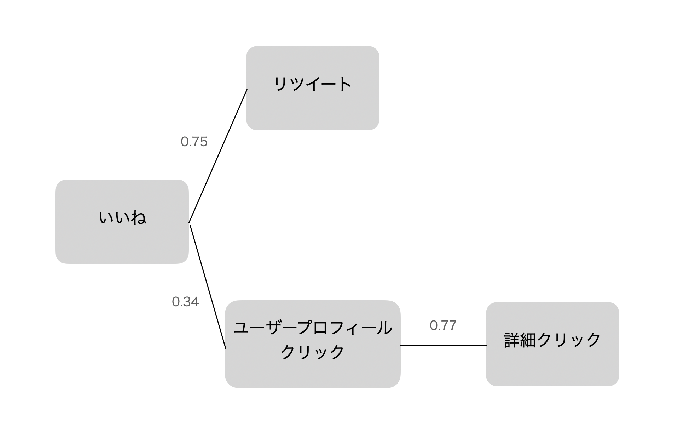

In [23]:
fig = plt.figure(figsize=(12,8))
axes = fig.add_subplot(111)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
axes.axis("off")

axes.imshow(mpimg.imread("/Users/Shared/SNS分析/twitter/data/graphical_model.png"))

## 探索②

In [24]:
tw.columns

Index(['ツイートID', 'ツイート本文_x', '時間', 'media_exist', 'reply_flg', 'URLクリック数',
       'いいね', 'インプレッション', 'エンゲージメント', 'エンゲージメント率', 'ハッシュタグクリック', 'フォローしている',
       'メディアのエンゲージメント数', 'メディアの再生数', 'ユーザープロフィールクリック', 'リツイート', '詳細クリック', '返信',
       '文字数', 'MD', 'MONTH', 'DAY', 'TIME', 'WEEKDAY', 'WEEK'],
      dtype='object')

In [86]:
tar_cols = ['URLクリック数','いいね', 'インプレッション', 'ハッシュタグクリック', 'フォローしている',
           'ユーザープロフィールクリック', 'リツイート', '詳細クリック', '文字数']
sample_cor = tw[tar_cols].corr()
column_names = tw[tar_cols].columns
estimated_cors = [sample_cor]

In [87]:
rounding = 0.004
print('inverse of correlation')

tmp_df = pd.DataFrame(inverse_cor(estimated_cors[-1]), index=column_names, columns=column_names)
print('*'*10,'カラムごと絶対値最小','*'*10)
print(np.abs(tmp_df).min())
abs_arr = np.abs(np.ravel(tmp_df.values))
print('*'*10,'絶対値最小','*'*10)
m = np.min(abs_arr[abs_arr > rounding])
print(m)
print("↑四捨五入",round(m,2))
print(s)
if len(s) == 2:
  print("次のターゲット", (tmp_df.index.get_loc(s[0]), tmp_df.columns.get_loc(s[1])))
else:
  print("ターゲットいっぱい")

display(tmp_df)

inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.03
インプレッション         0.03
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.06
リツイート            0.01
詳細クリック           0.09
文字数              0.03
dtype: float64
********** 絶対値最小 **********
0.011581098622476069
↑四捨五入 0.01
Index(['いいね', 'フォローしている'], dtype='object')
次のターゲット (1, 4)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.07     -0.27        0.01      0.00   
いいね                 0.07  1.00     -0.56        0.32      0.03   
インプレッション           -0.27 -0.56      1.00       -0.26     -0.07   
ハッシュタグクリック          0.01  0.32     -0.26        1.00     -0.00   
フォローしている            0.00  0.03     -0.07       -0.00      1.00   
ユーザープロフィールクリック      0.15 -0.49      0.06       -0.47      0.08   
リツイート              -0.03 -0.38     -0.34        0.03     -0.01   
詳細クリック             -0.14  0.49     -0.40        0.32     -0.09   
文字数                -0.10  0.13     -0.03       -0.26     -0.07   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.15  -0.03   -0.14 -0.10  
いいね                      -0.49  -0.38    0.49  0.13  
インプレッション                  0.06  -0.34   -0.40 -0.03  
ハッシュタグクリック               -0.47   0.03    0.32 -0.26  
フォローしている                  0.08  -0.01   -0.09 -0.07  
ユーザープロフィールクリック            1.00   0.14   -0.76 -0.11  
リツイート                     0.14   1.00   -0.09 -0.03  
詳細クリック                   -0.76  -0.09    1.00  0.10  
文字数                      -0.11  -0.03    0.10  1.00

In [88]:
cond_ind_pairs = [(0, 3)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.22      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.22 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== test rel to original ========
dev: 0.0016934177400980133
p: 0.96717539155639
======== test rel to prev ========
dev: 0.0016934177400980133
p: 0.96717539155639
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.03
インプレッション         0.03
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.05
リツイート            0.01
詳細クリック           0.09
文字数              0.03
dtype: float64
********** 絶対値最小 **********
0.011581770099293105
↑四捨五入 0.01
Index(['フォローしている', 'リツイート'], dtype='object')
次のターゲット (4, 6)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.07     -0.26       -0.00      0.00   
いいね                 0.07  1.00     -0.56        0.31      0.03   
インプレッション           -0.26 -0.56      1.00       -0.26     -0.07   
ハッシュタグクリック         -0.00  0.31     -0.26        1.00     -0.00   
フォローしている            0.00  0.03     -0.07       -0.00      1.00   
ユーザープロフィールクリック      0.16 -0.49      0.05       -0.47      0.08   
リツイート              -0.03 -0.38     -0.34        0.03     -0.01   
詳細クリック             -0.14  0.49     -0.40        0.32     -0.09   
文字数                -0.10  0.13     -0.03       -0.26     -0.07   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.16  -0.03   -0.14 -0.10  
いいね                      -0.49  -0.38    0.49  0.13  
インプレッション                  0.05  -0.34   -0.40 -0.03  
ハッシュタグクリック               -0.47   0.03    0.32 -0.26  
フォローしている                  0.08  -0.01   -0.09 -0.07  
ユーザープロフィールクリック            1.00   0.14   -0.76 -0.11  
リツイート                     0.14   1.00   -0.09 -0.03  
詳細クリック                   -0.76  -0.09    1.00  0.10  
文字数                      -0.11  -0.03    0.10  1.00

In [89]:
cond_ind_pairs = [(0, 3),(4, 6)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.22      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.22 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== test rel to original ========
dev: 0.0029007353057952656
p: 0.9985506836219602
======== test rel to prev ========
dev: 0.0012073175656972523
p: 0.9722819011238605
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.02
インプレッション         0.03
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.05
リツイート            0.00
詳細クリック           0.09
文字数              0.03
dtype: float64
********** 絶対値最小 **********
0.022855355370550702
↑四捨五入 0.02
Index(['いいね', 'フォローしている'], dtype='object')
次のターゲット (1, 4)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.07     -0.26        0.00      0.00   
いいね                 0.07  1.00     -0.56        0.31      0.02   
インプレッション           -0.26 -0.56      1.00       -0.26     -0.07   
ハッシュタグクリック          0.00  0.31     -0.26        1.00      0.00   
フォローしている            0.00  0.02     -0.07        0.00      1.00   
ユーザープロフィールクリック      0.16 -0.49      0.05       -0.47      0.08   
リツイート              -0.03 -0.38     -0.34        0.03     -0.00   
詳細クリック             -0.14  0.49     -0.40        0.32     -0.09   
文字数                -0.10  0.13     -0.03       -0.26     -0.07   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.16  -0.03   -0.14 -0.10  
いいね                      -0.49  -0.38    0.49  0.13  
インプレッション                  0.05  -0.34   -0.40 -0.03  
ハッシュタグクリック               -0.47   0.03    0.32 -0.26  
フォローしている                  0.08  -0.00   -0.09 -0.07  
ユーザープロフィールクリック            1.00   0.14   -0.76 -0.11  
リツイート                     0.14   1.00   -0.09 -0.03  
詳細クリック                   -0.76  -0.09    1.00  0.10  
文字数                      -0.11  -0.03    0.10  1.00

In [90]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.22      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.14            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.22 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.14      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== test rel to original ========
dev: 0.008375557778752096
p: 0.9997966480043614
======== test rel to prev ========
dev: 0.005474822472956831
p: 0.9410167164269384
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.03
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.05
リツイート            0.00
詳細クリック           0.09
文字数              0.03
dtype: float64
********** 絶対値最小 **********
0.008509492199394654
↑四捨五入 0.01
Index(['ハッシュタグクリック', 'フォローしている'], dtype='object')
次のターゲット (3, 4)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.07     -0.26        0.00     -0.00   
いいね                 0.07  1.00     -0.56        0.31     -0.00   
インプレッション           -0.26 -0.56      1.00       -0.26     -0.06   
ハッシュタグクリック          0.00  0.31     -0.26        1.00     -0.01   
フォローしている           -0.00 -0.00     -0.06       -0.01      1.00   
ユーザープロフィールクリック      0.16 -0.50      0.05       -0.47      0.09   
リツイート              -0.03 -0.38     -0.34        0.03      0.00   
詳細クリック             -0.14  0.49     -0.40        0.32     -0.10   
文字数                -0.10  0.13     -0.03       -0.26     -0.08   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.16  -0.03   -0.14 -0.10  
いいね                      -0.50  -0.38    0.49  0.13  
インプレッション                  0.05  -0.34   -0.40 -0.03  
ハッシュタグクリック               -0.47   0.03    0.32 -0.26  
フォローしている                  0.09   0.00   -0.10 -0.08  
ユーザープロフィールクリック            1.00   0.14   -0.76 -0.11  
リツイート                     0.14   1.00   -0.09 -0.03  
詳細クリック                   -0.76  -0.09    1.00  0.11  
文字数                      -0.11  -0.03    0.11  1.00

In [91]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.22      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.14            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.22 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.14 0.14      0.19        0.07      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== test rel to original ========
dev: 0.009122192276052488
p: 0.999989629776047
======== test rel to prev ========
dev: 0.0007466344973003913
p: 0.9782008255435819
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.03
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.06
リツイート            0.00
詳細クリック           0.09
文字数              0.03
dtype: float64
********** 絶対値最小 **********
0.02952612756335378
↑四捨五入 0.03
Index(['URLクリック数', 'インプレッション', 'ハッシュタグクリック', 'リツイート', 'リツイート', 'リツイート', '文字数',
       '文字数'],
      dtype='object')
次のターゲット (0, 2)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.07     -0.26        0.00     -0.00   
いいね                 0.07  1.00     -0.56        0.31      0.00   
インプレッション           -0.26 -0.56      1.00       -0.26     -0.06   
ハッシュタグクリック         -0.00  0.31     -0.26        1.00     -0.00   
フォローしている           -0.00  0.00     -0.06       -0.00      1.00   
ユーザープロフィールクリック      0.16 -0.50      0.06       -0.47      0.09   
リツイート              -0.03 -0.38     -0.34        0.03      0.00   
詳細クリック             -0.14  0.49     -0.40        0.32     -0.10   
文字数                -0.10  0.13     -0.03       -0.26     -0.08   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.16  -0.03   -0.14 -0.10  
いいね                      -0.50  -0.38    0.49  0.13  
インプレッション                  0.06  -0.34   -0.40 -0.03  
ハッシュタグクリック               -0.47   0.03    0.32 -0.26  
フォローしている                  0.09   0.00   -0.10 -0.08  
ユーザープロフィールクリック            1.00   0.14   -0.76 -0.11  
リツイート                     0.14   1.00   -0.09 -0.03  
詳細クリック                   -0.76  -0.09    1.00  0.11  
文字数                      -0.11  -0.03    0.11  1.00

In [92]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.22      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.14            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.22 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.14 0.14      0.19        0.07      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.50 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.50    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== test rel to original ========
dev: 0.016981111874152077
p: 0.9999980133060815
======== test rel to prev ========
dev: 0.00785891959809959
p: 0.9293596349783013
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.03
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.05
リツイート            0.00
詳細クリック           0.10
文字数              0.03
dtype: float64
********** 絶対値最小 **********
0.03021740326791592
↑四捨五入 0.03
Index(['インプレッション', 'ハッシュタグクリック', 'リツイート', '文字数'], dtype='object')
次のターゲット (2, 3)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.06     -0.27        0.00     -0.00   
いいね                 0.06  1.00     -0.55        0.31      0.00   
インプレッション           -0.27 -0.55      1.00       -0.26     -0.06   
ハッシュタグクリック          0.00  0.31     -0.26        1.00     -0.00   
フォローしている           -0.00  0.00     -0.06       -0.00      1.00   
ユーザープロフィールクリック      0.16 -0.50      0.05       -0.47      0.09   
リツイート              -0.00 -0.37     -0.35        0.03      0.00   
詳細クリック             -0.14  0.49     -0.39        0.32     -0.10   
文字数                -0.10  0.13     -0.03       -0.26     -0.08   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.16  -0.00   -0.14 -0.10  
いいね                      -0.50  -0.37    0.49  0.13  
インプレッション                  0.05  -0.35   -0.39 -0.03  
ハッシュタグクリック               -0.47   0.03    0.32 -0.26  
フォローしている                  0.09   0.00   -0.10 -0.08  
ユーザープロフィールクリック            1.00   0.15   -0.76 -0.11  
リツイート                     0.15   1.00   -0.10 -0.04  
詳細クリック                   -0.76  -0.10    1.00  0.11  
文字数                      -0.11  -0.04    0.11  1.00

In [93]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.22      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.14            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.22 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.14 0.14      0.19        0.07      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.50 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.50    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== test rel to original ========
dev: 0.025332339921011027
p: 0.9999996645248506
======== test rel to prev ========
dev: 0.00835122804685895
p: 0.9271866374415281
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.05
リツイート            0.00
詳細クリック           0.09
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.03755877899522162
↑四捨五入 0.04
Index(['ハッシュタグクリック', 'リツイート'], dtype='object')
次のターゲット (3, 6)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.06     -0.27        0.00      0.00   
いいね                 0.06  1.00     -0.55        0.32      0.00   
インプレッション           -0.27 -0.55      1.00       -0.26     -0.06   
ハッシュタグクリック          0.00  0.32     -0.26        1.00      0.00   
フォローしている            0.00  0.00     -0.06        0.00      1.00   
ユーザープロフィールクリック      0.17 -0.50      0.05       -0.47      0.09   
リツイート               0.00 -0.38     -0.35        0.04      0.00   
詳細クリック             -0.14  0.49     -0.39        0.33     -0.10   
文字数                -0.10  0.11      0.00       -0.27     -0.08   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.17   0.00   -0.14 -0.10  
いいね                      -0.50  -0.38    0.49  0.11  
インプレッション                  0.05  -0.35   -0.39  0.00  
ハッシュタグクリック               -0.47   0.04    0.33 -0.27  
フォローしている                  0.09   0.00   -0.10 -0.08  
ユーザープロフィールクリック            1.00   0.15   -0.76 -0.11  
リツイート                     0.15   1.00   -0.10 -0.05  
詳細クリック                   -0.76  -0.10    1.00  0.09  
文字数                      -0.11  -0.05    0.09  1.00

In [94]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.22      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.14            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.22 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.14 0.14      0.19        0.07      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.50 0.88      0.89        0.30      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.10        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.50    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.10  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== test rel to original ========
dev: 0.038172236866314435
p: 0.9999999186377614
======== test rel to prev ========
dev: 0.012839896945303408
p: 0.9097821978058
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.04
リツイート            0.00
詳細クリック           0.09
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.037084613092734864
↑四捨五入 0.04
Index(['インプレッション', 'ユーザープロフィールクリック', 'リツイート', '文字数'], dtype='object')
次のターゲット (2, 5)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.06     -0.27        0.00      0.00   
いいね                 0.06  1.00     -0.55        0.33      0.00   
インプレッション           -0.27 -0.55      1.00       -0.25     -0.06   
ハッシュタグクリック          0.00  0.33     -0.25        1.00      0.00   
フォローしている            0.00  0.00     -0.06        0.00      1.00   
ユーザープロフィールクリック      0.17 -0.50      0.04       -0.47      0.09   
リツイート               0.00 -0.39     -0.34        0.00      0.00   
詳細クリック             -0.14  0.49     -0.39        0.33     -0.10   
文字数                -0.11  0.11     -0.00       -0.27     -0.08   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.17   0.00   -0.14 -0.11  
いいね                      -0.50  -0.39    0.49  0.11  
インプレッション                  0.04  -0.34   -0.39 -0.00  
ハッシュタグクリック               -0.47  -0.00    0.33 -0.27  
フォローしている                  0.09   0.00   -0.10 -0.08  
ユーザープロフィールクリック            1.00   0.16   -0.76 -0.11  
リツイート                     0.16   1.00   -0.11 -0.04  
詳細クリック                   -0.76  -0.11    1.00  0.09  
文字数                      -0.11  -0.04    0.09  1.00

In [95]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.22      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.14            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.22 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.14 0.14      0.19        0.07      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.50 0.88      0.89        0.30      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.50    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== test rel to original ========
dev: 0.05619465579049354
p: 0.9999999746083219
======== test rel to prev ========
dev: 0.018022418924179107
p: 0.8932067847790743
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.09
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.03770277384994048
↑四捨五入 0.04
Index(['リツイート', '文字数'], dtype='object')
次のターゲット (6, 8)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.06     -0.28       -0.00      0.00   
いいね                 0.06  1.00     -0.53        0.32      0.00   
インプレッション           -0.28 -0.53      1.00       -0.23     -0.06   
ハッシュタグクリック         -0.00  0.32     -0.23        1.00     -0.00   
フォローしている            0.00  0.00     -0.06       -0.00      1.00   
ユーザープロフィールクリック      0.18 -0.48      0.00       -0.46      0.09   
リツイート              -0.00 -0.39     -0.34       -0.00      0.00   
詳細クリック             -0.15  0.48     -0.36        0.32     -0.10   
文字数                -0.11  0.11      0.00       -0.27     -0.08   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.18  -0.00   -0.15 -0.11  
いいね                      -0.48  -0.39    0.48  0.11  
インプレッション                  0.00  -0.34   -0.36  0.00  
ハッシュタグクリック               -0.46  -0.00    0.32 -0.27  
フォローしている                  0.09   0.00   -0.10 -0.08  
ユーザープロフィールクリック            1.00   0.18   -0.75 -0.11  
リツイート                     0.18   1.00   -0.12 -0.04  
詳細クリック                   -0.75  -0.12    1.00  0.09  
文字数                      -0.11  -0.04    0.09  1.00

In [96]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.22      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.14            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.22 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.14 0.14      0.19        0.07      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.50 0.88      0.89        0.30      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.10        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.50    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.10  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.04  
詳細クリック           0.71    1.00 0.11  
文字数              0.04    0.11 1.00

======== test rel to original ========
dev: 0.07201684948746134
p: 0.9999999940820226
======== test rel to prev ========
dev: 0.0158221936969678
p: 0.8999010852973653
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.08
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.058931117029566465
↑四捨五入 0.06
Index(['URLクリック数', 'いいね', 'インプレッション', 'フォローしている'], dtype='object')
次のターゲット (0, 1)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.06     -0.28        0.00      0.00   
いいね                 0.06  1.00     -0.53        0.32      0.00   
インプレッション           -0.28 -0.53      1.00       -0.24     -0.06   
ハッシュタグクリック          0.00  0.32     -0.24        1.00      0.00   
フォローしている            0.00  0.00     -0.06        0.00      1.00   
ユーザープロフィールクリック      0.18 -0.48      0.00       -0.46      0.10   
リツイート              -0.00 -0.39     -0.35       -0.00      0.00   
詳細クリック             -0.15  0.48     -0.36        0.32     -0.10   
文字数                -0.11  0.09     -0.00       -0.27     -0.08   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.18  -0.00   -0.15 -0.11  
いいね                      -0.48  -0.39    0.48  0.09  
インプレッション                  0.00  -0.35   -0.36 -0.00  
ハッシュタグクリック               -0.46  -0.00    0.32 -0.27  
フォローしている                  0.10   0.00   -0.10 -0.08  
ユーザープロフィールクリック            1.00   0.17   -0.75 -0.10  
リツイート                     0.17   1.00   -0.11  0.00  
詳細クリック                   -0.75  -0.11    1.00  0.08  
文字数                      -0.10  -0.00    0.08  1.00

In [97]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8), (0, 1)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.48      0.57        0.20      0.14            0.44   
いいね                 0.48 1.00      0.91        0.30      0.14            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.20 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.14 0.14      0.19        0.07      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.30      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.10        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.10  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.04  
詳細クリック           0.71    1.00 0.11  
文字数              0.04    0.11 1.00

======== test rel to original ========
dev: 0.11743968340964805
p: 0.9999999944600401
======== test rel to prev ========
dev: 0.04542283392218671
p: 0.8312284255060904
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.09
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.05987206267228109
↑四捨五入 0.06
Index(['インプレッション', 'フォローしている'], dtype='object')
次のターゲット (2, 4)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.24       -0.00      0.00   
いいね                -0.00  1.00     -0.52        0.32      0.00   
インプレッション           -0.24 -0.52      1.00       -0.24     -0.06   
ハッシュタグクリック         -0.00  0.32     -0.24        1.00      0.00   
フォローしている            0.00  0.00     -0.06        0.00      1.00   
ユーザープロフィールクリック      0.20 -0.49     -0.00       -0.46      0.10   
リツイート               0.00 -0.39     -0.35       -0.00      0.00   
詳細クリック             -0.18  0.48     -0.36        0.32     -0.10   
文字数                -0.13  0.09     -0.00       -0.27     -0.08   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.20   0.00   -0.18 -0.13  
いいね                      -0.49  -0.39    0.48  0.09  
インプレッション                 -0.00  -0.35   -0.36 -0.00  
ハッシュタグクリック               -0.46  -0.00    0.32 -0.27  
フォローしている                  0.10   0.00   -0.10 -0.08  
ユーザープロフィールクリック            1.00   0.17   -0.75 -0.11  
リツイート                     0.17   1.00   -0.11 -0.00  
詳細クリック                   -0.75  -0.11    1.00  0.09  
文字数                      -0.11  -0.00    0.09  1.00

In [98]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8), (0, 1), (2, 4)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.48      0.57        0.20      0.14            0.44   
いいね                 0.48 1.00      0.91        0.30      0.10            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.14            0.86   
ハッシュタグクリック          0.20 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.14 0.10      0.14        0.07      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.30      0.12            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.10        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.10  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.12    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.04  
詳細クリック           0.71    1.00 0.11  
文字数              0.04    0.11 1.00

======== test rel to original ========
dev: 0.2071778420774777
p: 0.9999999877826344
======== test rel to prev ========
dev: 0.08973815866782964
p: 0.7645102968799562
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.09
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.03684723266991923
↑四捨五入 0.04
Index(['URLクリック数', 'フォローしている'], dtype='object')
次のターゲット (0, 4)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.00     -0.24       -0.00     -0.04   
いいね                 0.00  1.00     -0.52        0.32     -0.00   
インプレッション           -0.24 -0.52      1.00       -0.24      0.00   
ハッシュタグクリック         -0.00  0.32     -0.24        1.00     -0.00   
フォローしている           -0.04 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.20 -0.48      0.00       -0.46      0.05   
リツイート               0.00 -0.39     -0.35       -0.00     -0.00   
詳細クリック             -0.17  0.48     -0.36        0.32     -0.11   
文字数                -0.12  0.09     -0.00       -0.27     -0.07   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.20   0.00   -0.17 -0.12  
いいね                      -0.48  -0.39    0.48  0.09  
インプレッション                  0.00  -0.35   -0.36 -0.00  
ハッシュタグクリック               -0.46  -0.00    0.32 -0.27  
フォローしている                  0.05  -0.00   -0.11 -0.07  
ユーザープロフィールクリック            1.00   0.17   -0.75 -0.11  
リツイート                     0.17   1.00   -0.11  0.00  
詳細クリック                   -0.75  -0.11    1.00  0.09  
文字数                      -0.11   0.00    0.09  1.00

In [99]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8), (0, 1), (2, 4), (0, 4)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.48      0.57        0.20      0.10            0.44   
いいね                 0.48 1.00      0.91        0.30      0.10            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.13            0.86   
ハッシュタグクリック          0.20 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.10 0.10      0.13        0.07      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.30      0.11            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.10        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.10  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.11    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.04  
詳細クリック           0.71    1.00 0.11  
文字数              0.04    0.11 1.00

======== test rel to original ========
dev: 0.22176032892789088
p: 0.9999999976527661
======== test rel to prev ========
dev: 0.01458248685041319
p: 0.9038827430211077
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.09
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.05366917755259491
↑四捨五入 0.05
Index(['フォローしている', 'ユーザープロフィールクリック'], dtype='object')
次のターゲット (4, 5)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.00     -0.24        0.00     -0.00   
いいね                 0.00  1.00     -0.52        0.32     -0.00   
インプレッション           -0.24 -0.52      1.00       -0.24     -0.00   
ハッシュタグクリック          0.00  0.32     -0.24        1.00     -0.00   
フォローしている           -0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.20 -0.48      0.00       -0.46      0.05   
リツイート               0.00 -0.39     -0.35       -0.00     -0.00   
詳細クリック             -0.18  0.48     -0.36        0.31     -0.12   
文字数                -0.13  0.09     -0.00       -0.27     -0.08   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.20   0.00   -0.18 -0.13  
いいね                      -0.48  -0.39    0.48  0.09  
インプレッション                  0.00  -0.35   -0.36 -0.00  
ハッシュタグクリック               -0.46  -0.00    0.31 -0.27  
フォローしている                  0.05  -0.00   -0.12 -0.08  
ユーザープロフィールクリック            1.00   0.17   -0.75 -0.11  
リツイート                     0.17   1.00   -0.11  0.00  
詳細クリック                   -0.75  -0.11    1.00  0.09  
文字数                      -0.11   0.00    0.09  1.00

In [100]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8), (0, 1), (2, 4), (0, 4), (4, 5)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.48      0.57        0.20      0.10            0.44   
いいね                 0.48 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.16            0.86   
ハッシュタグクリック          0.20 0.30      0.42        1.00      0.10            0.53   
フォローしている            0.10 0.13      0.16        0.10      1.00            0.17   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.17            1.00   
リツイート               0.51 0.88      0.89        0.30      0.13            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.10        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.10  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.13    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.04  
詳細クリック           0.71    1.00 0.11  
文字数              0.04    0.11 1.00

======== test rel to original ========
dev: 0.27635326407325955
p: 0.9999999987732933
======== test rel to prev ========
dev: 0.05459293514536867
p: 0.8152556896410464
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.07
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.06264625547772876
↑四捨五入 0.06
Index(['フォローしている', '文字数'], dtype='object')
次のターゲット (4, 8)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.24       -0.00     -0.00   
いいね                -0.00  1.00     -0.52        0.32      0.00   
インプレッション           -0.24 -0.52      1.00       -0.24      0.00   
ハッシュタグクリック         -0.00  0.32     -0.24        1.00      0.00   
フォローしている           -0.00  0.00      0.00        0.00      1.00   
ユーザープロフィールクリック      0.20 -0.49     -0.00       -0.46     -0.00   
リツイート               0.00 -0.39     -0.35        0.00      0.00   
詳細クリック             -0.18  0.48     -0.37        0.32     -0.07   
文字数                -0.13  0.09      0.00       -0.27     -0.06   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.20   0.00   -0.18 -0.13  
いいね                      -0.49  -0.39    0.48  0.09  
インプレッション                 -0.00  -0.35   -0.37  0.00  
ハッシュタグクリック               -0.46   0.00    0.32 -0.27  
フォローしている                 -0.00   0.00   -0.07 -0.06  
ユーザープロフィールクリック            1.00   0.17   -0.75 -0.10  
リツイート                     0.17   1.00   -0.11 -0.00  
詳細クリック                   -0.75  -0.11    1.00  0.08  
文字数                      -0.10  -0.00    0.08  1.00

In [101]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.48      0.57        0.20      0.09            0.44   
いいね                 0.48 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.15            0.86   
ハッシュタグクリック          0.20 0.30      0.42        1.00      0.07            0.53   
フォローしている            0.09 0.13      0.15        0.07      1.00            0.17   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.17            1.00   
リツイート               0.51 0.88      0.89        0.30      0.13            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.10        0.38      0.02            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.10  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.13    0.19 0.02  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.04  
詳細クリック           0.71    1.00 0.11  
文字数              0.04    0.11 1.00

======== test rel to original ========
dev: 0.31863374184446336
p: 0.999999999550295
======== test rel to prev ========
dev: 0.042280477771203806
p: 0.8370860565586415
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.07
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.06918831143627018
↑四捨五入 0.07
Index(['フォローしている', '詳細クリック'], dtype='object')
次のターゲット (4, 7)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.24       -0.00     -0.00   
いいね                -0.00  1.00     -0.52        0.32      0.00   
インプレッション           -0.24 -0.52      1.00       -0.24      0.00   
ハッシュタグクリック         -0.00  0.32     -0.24        1.00      0.00   
フォローしている           -0.00  0.00      0.00        0.00      1.00   
ユーザープロフィールクリック      0.20 -0.49     -0.00       -0.46     -0.00   
リツイート               0.00 -0.39     -0.35        0.00      0.00   
詳細クリック             -0.18  0.48     -0.37        0.32     -0.07   
文字数                -0.13  0.09      0.00       -0.27      0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.20   0.00   -0.18 -0.13  
いいね                      -0.49  -0.39    0.48  0.09  
インプレッション                 -0.00  -0.35   -0.37  0.00  
ハッシュタグクリック               -0.46   0.00    0.32 -0.27  
フォローしている                 -0.00   0.00   -0.07 -0.00  
ユーザープロフィールクリック            1.00   0.17   -0.75 -0.10  
リツイート                     0.17   1.00   -0.11  0.00  
詳細クリック                   -0.75  -0.11    1.00  0.08  
文字数                      -0.10   0.00    0.08  1.00

In [102]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.48      0.57        0.20      0.00            0.44   
いいね                 0.48 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.86   
ハッシュタグクリック          0.20 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.00            1.00   
リツイート               0.51 0.88      0.89        0.30      0.00            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.00            0.89   
文字数                 0.13 0.03      0.10        0.38      0.00            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.10  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.04  
詳細クリック           0.71    1.00 0.11  
文字数              0.04    0.11 1.00

======== test rel to original ========
dev: 0.6412898656257209
p: 0.9999999893985537
======== test rel to prev ========
dev: 0.3226561237812575
p: 0.5700157672324575
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.07785392655242403
↑四捨五入 0.08
Index(['詳細クリック', '文字数'], dtype='object')
次のターゲット (7, 8)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.24        0.00      0.00   
いいね                -0.00  1.00     -0.52        0.32     -0.00   
インプレッション           -0.24 -0.52      1.00       -0.24     -0.00   
ハッシュタグクリック          0.00  0.32     -0.24        1.00     -0.00   
フォローしている            0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.20 -0.49     -0.00       -0.46     -0.00   
リツイート              -0.00 -0.39     -0.35        0.00     -0.00   
詳細クリック             -0.18  0.48     -0.37        0.32     -0.00   
文字数                -0.13  0.09      0.00       -0.27      0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.20  -0.00   -0.18 -0.13  
いいね                      -0.49  -0.39    0.48  0.09  
インプレッション                 -0.00  -0.35   -0.37  0.00  
ハッシュタグクリック               -0.46   0.00    0.32 -0.27  
フォローしている                 -0.00  -0.00   -0.00  0.00  
ユーザープロフィールクリック            1.00   0.17   -0.75 -0.10  
リツイート                     0.17   1.00   -0.11 -0.00  
詳細クリック                   -0.75  -0.11    1.00  0.08  
文字数                      -0.10  -0.00    0.08  1.00

In [103]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7), (7, 8)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.48      0.57        0.20      0.00            0.44   
いいね                 0.48 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.86   
ハッシュタグクリック          0.20 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.00            1.00   
リツイート               0.51 0.88      0.89        0.30      0.00            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.00            0.89   
文字数                 0.13 0.03      0.11        0.38      0.00            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.05  
詳細クリック           0.71    1.00 0.15  
文字数              0.05    0.15 1.00

======== test rel to original ========
dev: 0.710507896156475
p: 0.9999999954088237
======== test rel to prev ========
dev: 0.06921803053075415
p: 0.7924787469775467
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.03398364629963817
↑四捨五入 0.03
Index(['ユーザープロフィールクリック', '文字数'], dtype='object')
次のターゲット (5, 8)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.00     -0.24       -0.00      0.00   
いいね                 0.00  1.00     -0.52        0.32     -0.00   
インプレッション           -0.24 -0.52      1.00       -0.24     -0.00   
ハッシュタグクリック         -0.00  0.32     -0.24        1.00     -0.00   
フォローしている            0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.19 -0.48     -0.00       -0.47     -0.00   
リツイート               0.00 -0.39     -0.35        0.00     -0.00   
詳細クリック             -0.17  0.48     -0.37        0.34     -0.00   
文字数                -0.10  0.08      0.00       -0.29      0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.19   0.00   -0.17 -0.10  
いいね                      -0.48  -0.39    0.48  0.08  
インプレッション                 -0.00  -0.35   -0.37  0.00  
ハッシュタグクリック               -0.47   0.00    0.34 -0.29  
フォローしている                 -0.00  -0.00   -0.00  0.00  
ユーザープロフィールクリック            1.00   0.17   -0.74 -0.03  
リツイート                     0.17   1.00   -0.11  0.00  
詳細クリック                   -0.74  -0.11    1.00  0.00  
文字数                      -0.03   0.00   -0.00  1.00

In [104]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7), (7, 8), (5, 8)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.48      0.57        0.20      0.00            0.44   
いいね                 0.48 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.86   
ハッシュタグクリック          0.20 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.00            1.00   
リツイート               0.51 0.88      0.89        0.30      0.00            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.00            0.89   
文字数                 0.13 0.03      0.10        0.38      0.00            0.15   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.10  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.74    0.89 0.15  
リツイート            1.00    0.71 0.05  
詳細クリック           0.71    1.00 0.12  
文字数              0.05    0.12 1.00

======== test rel to original ========
dev: 0.7398196066309772
p: 0.9999999987155019
======== test rel to prev ========
dev: 0.029311710474502206
p: 0.8640612937494128
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.051423218807117595
↑四捨五入 0.05
Index(['いいね', '文字数'], dtype='object')
次のターゲット (1, 8)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.23        0.00      0.00   
いいね                -0.00  1.00     -0.52        0.32     -0.00   
インプレッション           -0.23 -0.52      1.00       -0.23     -0.00   
ハッシュタグクリック          0.00  0.32     -0.23        1.00     -0.00   
フォローしている            0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.19 -0.48      0.00       -0.48     -0.00   
リツイート              -0.00 -0.39     -0.35       -0.00     -0.00   
詳細クリック             -0.17  0.48     -0.37        0.33     -0.00   
文字数                -0.10  0.05     -0.00       -0.32     -0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.19  -0.00   -0.17 -0.10  
いいね                      -0.48  -0.39    0.48  0.05  
インプレッション                  0.00  -0.35   -0.37 -0.00  
ハッシュタグクリック               -0.48  -0.00    0.33 -0.32  
フォローしている                 -0.00  -0.00   -0.00 -0.00  
ユーザープロフィールクリック            1.00   0.17   -0.75 -0.00  
リツイート                     0.17   1.00   -0.11  0.00  
詳細クリック                   -0.75  -0.11    1.00 -0.00  
文字数                      -0.00   0.00   -0.00  1.00

In [105]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7), (7, 8), (5, 8), (1, 8)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.49      0.57        0.19      0.00            0.44   
いいね                 0.49 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.86   
ハッシュタグクリック          0.19 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.00            1.00   
リツイート               0.51 0.88      0.89        0.30      0.00            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.00            0.89   
文字数                 0.13 0.14      0.19        0.38      0.00            0.22   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.14  
インプレッション         0.89    0.83 0.19  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.74    0.89 0.22  
リツイート            1.00    0.71 0.14  
詳細クリック           0.71    1.00 0.18  
文字数              0.14    0.18 1.00

======== test rel to original ========
dev: 0.9111140996799172
p: 0.9999999984531902
======== test rel to prev ========
dev: 0.17129449304893996
p: 0.6789639040085971
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.05393821698514886
↑四捨五入 0.05
Index(['URLクリック数', '文字数'], dtype='object')
次のターゲット (0, 8)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.00     -0.23       -0.00      0.00   
いいね                 0.00  1.00     -0.52        0.34     -0.00   
インプレッション           -0.23 -0.52      1.00       -0.24     -0.00   
ハッシュタグクリック         -0.00  0.34     -0.24        1.00     -0.00   
フォローしている            0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.19 -0.48     -0.00       -0.48     -0.00   
リツイート               0.00 -0.39     -0.36        0.00     -0.00   
詳細クリック             -0.17  0.48     -0.37        0.33     -0.00   
文字数                -0.05 -0.00      0.00       -0.29      0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.19   0.00   -0.17 -0.05  
いいね                      -0.48  -0.39    0.48 -0.00  
インプレッション                 -0.00  -0.36   -0.37  0.00  
ハッシュタグクリック               -0.48   0.00    0.33 -0.29  
フォローしている                 -0.00  -0.00   -0.00  0.00  
ユーザープロフィールクリック            1.00   0.17   -0.74  0.00  
リツイート                     0.17   1.00   -0.11  0.00  
詳細クリック                   -0.74  -0.11    1.00  0.00  
文字数                       0.00   0.00    0.00  1.00

In [106]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), 
                  (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7), (7, 8), (5, 8), (1, 8),
                  (0, 8)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.49      0.57        0.17      0.00            0.44   
いいね                 0.49 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.86   
ハッシュタグクリック          0.17 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.00            1.00   
リツイート               0.51 0.88      0.89        0.30      0.00            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.00            0.89   
文字数                 0.07 0.12      0.16        0.38      0.00            0.21   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.07  
いいね              0.88    0.69 0.12  
インプレッション         0.89    0.83 0.16  
ハッシュタグクリック       0.30    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.74    0.89 0.21  
リツイート            1.00    0.71 0.12  
詳細クリック           0.71    1.00 0.15  
文字数              0.12    0.15 1.00

======== test rel to original ========
dev: 0.9526189715399767
p: 0.9999999995001609
======== test rel to prev ========
dev: 0.04150487186005947
p: 0.8385664939205401
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.11363626053763973
↑四捨五入 0.11
Index(['リツイート', '詳細クリック'], dtype='object')
次のターゲット (6, 7)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.23       -0.00      0.00   
いいね                -0.00  1.00     -0.52        0.34     -0.00   
インプレッション           -0.23 -0.52      1.00       -0.24     -0.00   
ハッシュタグクリック         -0.00  0.34     -0.24        1.00     -0.00   
フォローしている            0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.18 -0.48      0.00       -0.48     -0.00   
リツイート               0.00 -0.39     -0.36       -0.00     -0.00   
詳細クリック             -0.17  0.48     -0.37        0.33     -0.00   
文字数                 0.00 -0.00     -0.00       -0.30     -0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.18   0.00   -0.17  0.00  
いいね                      -0.48  -0.39    0.48 -0.00  
インプレッション                  0.00  -0.36   -0.37 -0.00  
ハッシュタグクリック               -0.48  -0.00    0.33 -0.30  
フォローしている                 -0.00  -0.00   -0.00 -0.00  
ユーザープロフィールクリック            1.00   0.17   -0.74 -0.00  
リツイート                     0.17   1.00   -0.11 -0.00  
詳細クリック                   -0.74  -0.11    1.00 -0.00  
文字数                      -0.00  -0.00   -0.00  1.00

In [107]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), 
                  (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7), (7, 8), (5, 8), (1, 8),
                  (0, 8), (6, 7)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.49      0.57        0.17      0.00            0.44   
いいね                 0.49 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.86   
ハッシュタグクリック          0.17 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.00            1.00   
リツイート               0.50 0.88      0.89        0.31      0.00            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.00            0.89   
文字数                 0.07 0.12      0.16        0.38      0.00            0.21   

                リツイート  詳細クリック  文字数  
URLクリック数         0.50    0.50 0.07  
いいね              0.88    0.69 0.12  
インプレッション         0.89    0.83 0.16  
ハッシュタグクリック       0.31    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.74    0.89 0.21  
リツイート            1.00    0.69 0.12  
詳細クリック           0.69    1.00 0.15  
文字数              0.12    0.15 1.00

======== test rel to original ========
dev: 1.094196885303969
p: 0.99999999959696
======== test rel to prev ========
dev: 0.1415779137639923
p: 0.7067173643499224
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.10679894084533682
↑四捨五入 0.11
Index(['ユーザープロフィールクリック', 'リツイート'], dtype='object')
次のターゲット (5, 6)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.00     -0.23       -0.00      0.00   
いいね                 0.00  1.00     -0.51        0.34     -0.00   
インプレッション           -0.23 -0.51      1.00       -0.23     -0.00   
ハッシュタグクリック         -0.00  0.34     -0.23        1.00     -0.00   
フォローしている            0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.19 -0.45      0.00       -0.48     -0.00   
リツイート               0.00 -0.35     -0.40       -0.00     -0.00   
詳細クリック             -0.17  0.44     -0.39        0.33     -0.00   
文字数                 0.00 -0.00     -0.00       -0.30     -0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.19   0.00   -0.17  0.00  
いいね                      -0.45  -0.35    0.44 -0.00  
インプレッション                  0.00  -0.40   -0.39 -0.00  
ハッシュタグクリック               -0.48  -0.00    0.33 -0.30  
フォローしている                 -0.00  -0.00   -0.00 -0.00  
ユーザープロフィールクリック            1.00   0.11   -0.73 -0.00  
リツイート                     0.11   1.00    0.00 -0.00  
詳細クリック                   -0.73  -0.00    1.00 -0.00  
文字数                      -0.00  -0.00   -0.00  1.00

In [108]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), 
                  (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7), (7, 8), (5, 8), (1, 8),
                  (0, 8), (6, 7),(5, 6)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.49      0.57        0.17      0.00            0.44   
いいね                 0.49 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.87   
ハッシュタグクリック          0.17 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.44 0.80      0.87        0.53      0.00            1.00   
リツイート               0.50 0.88      0.89        0.34      0.00            0.78   
詳細クリック              0.50 0.69      0.83        0.39      0.00            0.89   
文字数                 0.07 0.12      0.16        0.38      0.00            0.21   

                リツイート  詳細クリック  文字数  
URLクリック数         0.50    0.50 0.07  
いいね              0.88    0.69 0.12  
インプレッション         0.89    0.83 0.16  
ハッシュタグクリック       0.34    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.78    0.89 0.21  
リツイート            1.00    0.71 0.13  
詳細クリック           0.71    1.00 0.15  
文字数              0.13    0.15 1.00

======== test rel to original ========
dev: 1.383971926519446
p: 0.9999999990629082
======== test rel to prev ========
dev: 0.2897750412154769
p: 0.5903647252068425
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.17950493603279663
↑四捨五入 0.18
Index(['URLクリック数', '詳細クリック'], dtype='object')
次のターゲット (0, 7)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.24       -0.00      0.00   
いいね                -0.00  1.00     -0.55        0.33     -0.00   
インプレッション           -0.24 -0.55      1.00       -0.22     -0.00   
ハッシュタグクリック         -0.00  0.33     -0.22        1.00     -0.00   
フォローしている            0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.20 -0.39      0.00       -0.47     -0.00   
リツイート               0.00 -0.34     -0.33        0.00     -0.00   
詳細クリック             -0.18  0.42     -0.38        0.31      0.00   
文字数                -0.00 -0.00     -0.00       -0.30     -0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.20   0.00   -0.18 -0.00  
いいね                      -0.39  -0.34    0.42 -0.00  
インプレッション                  0.00  -0.33   -0.38 -0.00  
ハッシュタグクリック               -0.47   0.00    0.31 -0.30  
フォローしている                 -0.00  -0.00    0.00 -0.00  
ユーザープロフィールクリック            1.00  -0.00   -0.73 -0.00  
リツイート                    -0.00   1.00    0.00 -0.00  
詳細クリック                   -0.73   0.00    1.00 -0.00  
文字数                      -0.00  -0.00   -0.00  1.00

In [109]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), 
                  (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7), (7, 8), (5, 8), (1, 8),
                  (0, 8), (6, 7),(5, 6), (0, 7)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.52      0.57        0.20      0.00            0.44   
いいね                 0.52 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.87   
ハッシュタグクリック          0.20 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.44 0.80      0.87        0.53      0.00            1.00   
リツイート               0.51 0.88      0.89        0.34      0.00            0.78   
詳細クリック              0.43 0.69      0.83        0.39      0.00            0.89   
文字数                 0.08 0.12      0.16        0.38      0.00            0.20   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.43 0.08  
いいね              0.88    0.69 0.12  
インプレッション         0.89    0.83 0.16  
ハッシュタグクリック       0.34    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.78    0.89 0.20  
リツイート            1.00    0.71 0.13  
詳細クリック           0.71    1.00 0.15  
文字数              0.13    0.15 1.00

======== test rel to original ========
dev: 1.775632937562695
p: 0.9999999969939295
======== test rel to prev ========
dev: 0.391661011043249
p: 0.5314275936146469
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.09621467094227652
↑四捨五入 0.1
Index(['URLクリック数', 'ユーザープロフィールクリック'], dtype='object')
次のターゲット (0, 5)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.27       -0.00      0.00   
いいね                -0.00  1.00     -0.55        0.32     -0.00   
インプレッション           -0.27 -0.55      1.00       -0.21     -0.00   
ハッシュタグクリック         -0.00  0.32     -0.21        1.00     -0.00   
フォローしている            0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック      0.10 -0.38     -0.00       -0.47     -0.00   
リツイート               0.00 -0.34     -0.33       -0.00     -0.00   
詳細クリック             -0.00  0.41     -0.41        0.31      0.00   
文字数                -0.00  0.00     -0.00       -0.30      0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.10   0.00   -0.00 -0.00  
いいね                      -0.38  -0.34    0.41  0.00  
インプレッション                 -0.00  -0.33   -0.41 -0.00  
ハッシュタグクリック               -0.47  -0.00    0.31 -0.30  
フォローしている                 -0.00  -0.00    0.00  0.00  
ユーザープロフィールクリック            1.00   0.00   -0.71  0.00  
リツイート                     0.00   1.00   -0.00 -0.00  
詳細クリック                   -0.71  -0.00    1.00  0.00  
文字数                       0.00  -0.00    0.00  1.00

In [110]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), 
                  (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7), (7, 8), (5, 8), (1, 8),
                  (0, 8), (6, 7),(5, 6), (0, 7), (0, 5)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.52      0.57        0.24      0.00            0.50   
いいね                 0.52 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.87   
ハッシュタグクリック          0.24 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.50 0.80      0.87        0.53      0.00            1.00   
リツイート               0.51 0.88      0.89        0.34      0.00            0.78   
詳細クリック              0.47 0.69      0.83        0.39      0.00            0.89   
文字数                 0.09 0.11      0.16        0.38      0.00            0.20   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.47 0.09  
いいね              0.88    0.69 0.11  
インプレッション         0.89    0.83 0.16  
ハッシュタグクリック       0.34    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.78    0.89 0.20  
リツイート            1.00    0.71 0.13  
詳細クリック           0.71    1.00 0.15  
文字数              0.13    0.15 1.00

======== test rel to original ========
dev: 1.9842624999453804
p: 0.9999999973138771
======== test rel to prev ========
dev: 0.20862956238268549
p: 0.6478436658206539
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.19461083197366447
↑四捨五入 0.19
Index(['URLクリック数', 'インプレッション'], dtype='object')
次のターゲット (0, 2)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.19        0.00      0.00   
いいね                -0.00  1.00     -0.55        0.31     -0.00   
インプレッション           -0.19 -0.55      1.00       -0.20     -0.00   
ハッシュタグクリック          0.00  0.31     -0.20        1.00     -0.00   
フォローしている            0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック     -0.00 -0.37      0.00       -0.47     -0.00   
リツイート              -0.00 -0.35     -0.34        0.00     -0.00   
詳細クリック              0.00  0.40     -0.40        0.31      0.00   
文字数                -0.00  0.00      0.00       -0.30      0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                 -0.00  -0.00    0.00 -0.00  
いいね                      -0.37  -0.35    0.40  0.00  
インプレッション                  0.00  -0.34   -0.40  0.00  
ハッシュタグクリック               -0.47   0.00    0.31 -0.30  
フォローしている                 -0.00  -0.00    0.00  0.00  
ユーザープロフィールクリック            1.00   0.00   -0.71  0.00  
リツイート                     0.00   1.00    0.00  0.00  
詳細クリック                   -0.71   0.00    1.00  0.00  
文字数                       0.00   0.00    0.00  1.00

In [111]:
cond_ind_pairs = [(0, 3),(4, 6),(1, 4), (3, 4), (0, 6), (2, 8), (3, 6), (2, 5), 
                  (6, 8), (0, 1), (2, 4), (0, 4), (4, 5), (4, 8), (4, 7), (7, 8), (5, 8), (1, 8),
                  (0, 8), (6, 7),(5, 6), (0, 7), (0, 5), (0, 2)]
search(cond_ind_pairs, rounding)

======== original ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

======== estimated ========


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.00      0.00        0.00      0.00            0.00   
いいね                 0.00 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.00 0.91      1.00        0.42      0.00            0.87   
ハッシュタグクリック          0.00 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.00 0.80      0.87        0.53      0.00            1.00   
リツイート               0.00 0.88      0.89        0.34      0.00            0.78   
詳細クリック              0.00 0.69      0.83        0.39      0.00            0.89   
文字数                 0.00 0.12      0.16        0.38      0.00            0.20   

                リツイート  詳細クリック  文字数  
URLクリック数         0.00    0.00 0.00  
いいね              0.88    0.69 0.12  
インプレッション         0.89    0.83 0.16  
ハッシュタグクリック       0.34    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.78    0.89 0.20  
リツイート            1.00    0.71 0.13  
詳細クリック           0.71    1.00 0.15  
文字数              0.13    0.15 1.00

======== test rel to original ========
dev: 5.555166182765162
p: 0.999965354287222
======== test rel to prev ========
dev: 3.5709036828197815
p: 0.058800303820103705
##################################################
inverse of correlation
********** カラムごと絶対値最小 **********
URLクリック数         0.00
いいね              0.00
インプレッション         0.00
ハッシュタグクリック       0.00
フォローしている         0.00
ユーザープロフィールクリック   0.00
リツイート            0.00
詳細クリック           0.00
文字数              0.00
dtype: float64
********** 絶対値最小 **********
0.20145291067202895
↑四捨五入 0.2
Index(['インプレッション', 'ハッシュタグクリック'], dtype='object')
次のターゲット (2, 3)


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00 -0.00     -0.00       -0.00     -0.00   
いいね                -0.00  1.00     -0.56        0.31     -0.00   
インプレッション           -0.00 -0.56      1.00       -0.20     -0.00   
ハッシュタグクリック         -0.00  0.31     -0.20        1.00     -0.00   
フォローしている           -0.00 -0.00     -0.00       -0.00      1.00   
ユーザープロフィールクリック     -0.00 -0.37     -0.00       -0.47     -0.00   
リツイート              -0.00 -0.35     -0.34       -0.00     -0.00   
詳細クリック             -0.00  0.40     -0.41        0.31      0.00   
文字数                -0.00  0.00     -0.00       -0.30     -0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                 -0.00  -0.00   -0.00 -0.00  
いいね                      -0.37  -0.35    0.40  0.00  
インプレッション                 -0.00  -0.34   -0.41 -0.00  
ハッシュタグクリック               -0.47  -0.00    0.31 -0.30  
フォローしている                 -0.00  -0.00    0.00 -0.00  
ユーザープロフィールクリック            1.00  -0.00   -0.71 -0.00  
リツイート                    -0.00   1.00    0.00 -0.00  
詳細クリック                   -0.71   0.00    1.00 -0.00  
文字数                      -0.00  -0.00   -0.00  1.00

p値が小さいので終了

## 結果②

In [112]:
# sample correlation
print('sample correlation', '標本相関係数')
display(pd.DataFrame(estimated_cors[0], index=column_names, columns=column_names))

# estimated correlation
print('estimated correlation', '相関係数の推定値')
display(pd.DataFrame(estimated_cors[-2], index=column_names, columns=column_names))

# estimated vs sample
print('estimated vs sample', '値の差')
display(pd.DataFrame(estimated_cors[-2] - estimated_cors[0], index=column_names, columns=column_names))

# compute partial correlation
print('partial correlation', '偏相関係数')
display(pd.DataFrame(inverse_cor(estimated_cors[-2]), index=column_names, columns=column_names).applymap(lambda x: -x if x < 1-1e-4 else 1))

sample correlation 標本相関係数


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.46      0.57        0.21      0.14            0.44   
いいね                 0.46 1.00      0.91        0.30      0.13            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.19            0.86   
ハッシュタグクリック          0.21 0.30      0.42        1.00      0.08            0.53   
フォローしている            0.14 0.13      0.19        0.08      1.00            0.14   
ユーザープロフィールクリック      0.44 0.80      0.86        0.53      0.14            1.00   
リツイート               0.51 0.88      0.89        0.29      0.16            0.74   
詳細クリック              0.50 0.69      0.83        0.39      0.19            0.89   
文字数                 0.13 0.03      0.11        0.38      0.09            0.18   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.50 0.13  
いいね              0.88    0.69 0.03  
インプレッション         0.89    0.83 0.11  
ハッシュタグクリック       0.29    0.39 0.38  
フォローしている         0.16    0.19 0.09  
ユーザープロフィールクリック   0.74    0.89 0.18  
リツイート            1.00    0.71 0.06  
詳細クリック           0.71    1.00 0.11  
文字数              0.06    0.11 1.00

estimated correlation 相関係数の推定値


URLクリック数  いいね  インプレッション  ハッシュタグクリック  フォローしている  ユーザープロフィールクリック  \
URLクリック数            1.00 0.52      0.57        0.24      0.00            0.50   
いいね                 0.52 1.00      0.91        0.30      0.00            0.80   
インプレッション            0.57 0.91      1.00        0.42      0.00            0.87   
ハッシュタグクリック          0.24 0.30      0.42        1.00      0.00            0.53   
フォローしている            0.00 0.00      0.00        0.00      1.00            0.00   
ユーザープロフィールクリック      0.50 0.80      0.87        0.53      0.00            1.00   
リツイート               0.51 0.88      0.89        0.34      0.00            0.78   
詳細クリック              0.47 0.69      0.83        0.39      0.00            0.89   
文字数                 0.09 0.11      0.16        0.38      0.00            0.20   

                リツイート  詳細クリック  文字数  
URLクリック数         0.51    0.47 0.09  
いいね              0.88    0.69 0.11  
インプレッション         0.89    0.83 0.16  
ハッシュタグクリック       0.34    0.39 0.38  
フォローしている         0.00    0.00 0.00  
ユーザープロフィールクリック   0.78    0.89 0.20  
リツイート            1.00    0.71 0.13  
詳細クリック           0.71    1.00 0.15  
文字数              0.13    0.15 1.00

estimated vs sample 値の差


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            0.00  0.06      0.00        0.03     -0.14   
いいね                 0.06  0.00      0.00        0.00     -0.13   
インプレッション            0.00  0.00      0.00        0.00     -0.19   
ハッシュタグクリック          0.03  0.00      0.00        0.00     -0.08   
フォローしている           -0.14 -0.13     -0.19       -0.08      0.00   
ユーザープロフィールクリック      0.06  0.00      0.02        0.00     -0.14   
リツイート               0.00  0.00      0.00        0.05     -0.16   
詳細クリック             -0.03  0.00      0.00        0.00     -0.19   
文字数                -0.04  0.08      0.05        0.00     -0.09   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.06   0.00   -0.03 -0.04  
いいね                       0.00   0.00    0.00  0.08  
インプレッション                  0.02   0.00    0.00  0.05  
ハッシュタグクリック                0.00   0.05    0.00  0.00  
フォローしている                 -0.14  -0.16   -0.19 -0.09  
ユーザープロフィールクリック            0.00   0.04    0.00  0.03  
リツイート                     0.04   0.00    0.01  0.07  
詳細クリック                    0.00   0.01    0.00  0.04  
文字数                       0.03   0.07    0.04  0.00

partial correlation 偏相関係数


URLクリック数   いいね  インプレッション  ハッシュタグクリック  フォローしている  \
URLクリック数            1.00  0.00      0.19       -0.00     -0.00   
いいね                 0.00  1.00      0.55       -0.31      0.00   
インプレッション            0.19  0.55      1.00        0.20      0.00   
ハッシュタグクリック         -0.00 -0.31      0.20        1.00      0.00   
フォローしている           -0.00  0.00      0.00        0.00      1.00   
ユーザープロフィールクリック      0.00  0.37     -0.00        0.47      0.00   
リツイート               0.00  0.35      0.34       -0.00      0.00   
詳細クリック             -0.00 -0.40      0.40       -0.31     -0.00   
文字数                 0.00 -0.00     -0.00        0.30     -0.00   

                ユーザープロフィールクリック  リツイート  詳細クリック   文字数  
URLクリック数                  0.00   0.00   -0.00  0.00  
いいね                       0.37   0.35   -0.40 -0.00  
インプレッション                 -0.00   0.34    0.40 -0.00  
ハッシュタグクリック                0.47  -0.00   -0.31  0.30  
フォローしている                  0.00   0.00   -0.00 -0.00  
ユーザープロフィールクリック            1.00  -0.00    0.71 -0.00  
リツイート                    -0.00   1.00   -0.00 -0.00  
詳細クリック                    0.71  -0.00    1.00 -0.00  
文字数                      -0.00  -0.00   -0.00  1.00

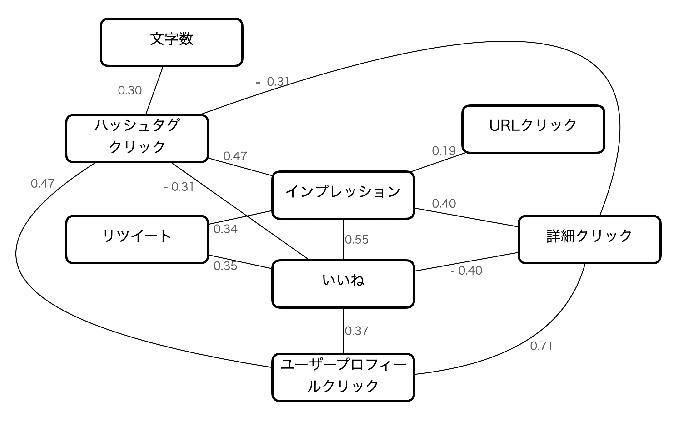

In [117]:
fig = plt.figure(figsize=(12,8))
axes = fig.add_subplot(111)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
axes.axis("off")
plt.grid(False) 

axes.imshow(mpimg.imread("/Users/Shared/SNS分析/twitter/data/graphical_model_2.png"))